In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
columns = [
    "CALLS_OI","CALLS_CHNG_OI","CALLS_VOLUME","CALLS_IV","CALLS_LTP","CALLS_CHNG",
    "CALLS_BID_QTY","CALLS_BID","CALLS_ASK","CALLS_ASK_QTY",
    "STRIKE",
    "PUTS_BID_QTY","PUTS_BID","PUTS_ASK","PUTS_ASK_QTY","PUTS_CHNG","PUTS_LTP",
    "PUTS_IV","PUTS_VOLUME","PUTS_CHNG_OI","PUTS_OI"
]

df = pd.read_csv("Data Files/optionchain.csv", skiprows=2,header=None)
print(df.shape[1])
df = df.drop([0, df.shape[1]-1], axis=1) # drops first and last empty column

print(df.shape[1])

df.columns=columns  # assigning new columns names to dataframe



df = df[df["CALLS_IV"] != "-"]
print(df.shape)

df.to_csv("cleaned-option-file.csv",index=False)


23
21
(59, 21)


In [3]:

S = 25600        # Spot price of NIFTY (example)
r = 0.065        # Risk-free rate (6.5%)
T = 5/365        # Time to expiry in years (example: 5 days left)

df["CALLS_IV"] = pd.to_numeric(df["CALLS_IV"].str.replace(",",""), errors="coerce")
df["PUTS_IV"]  = pd.to_numeric(df["PUTS_IV"].str.replace(",",""), errors="coerce")
df["STRIKE"]   = pd.to_numeric(df["STRIKE"].str.replace(",",""), errors="coerce")

# Function to compute Greeks
def greeks(row, S, r, T, option_type="call"):
    K = row["STRIKE"]
    sigma = row["CALLS_IV"]/100 if option_type=="call" else row["PUTS_IV"]/100
    
    if sigma == 0 or T == 0:
        return np.nan, np.nan, np.nan
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    delta = norm.cdf(d1) if option_type=="call" else norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S*sigma*np.sqrt(T))
    vega  = S * norm.pdf(d1) * np.sqrt(T)
    
    return delta, gamma, vega

# Apply for calls
df[["CALLS_DELTA","CALLS_GAMMA","CALLS_VEGA"]] = df.apply(
    lambda row: greeks(row, S, r, T, option_type="call"), axis=1, result_type="expand"
)

# Apply for puts
df[["PUTS_DELTA","PUTS_GAMMA","PUTS_VEGA"]] = df.apply(
    lambda row: greeks(row, S, r, T, option_type="put"), axis=1, result_type="expand"
)

df.to_csv("final-option-file.csv")

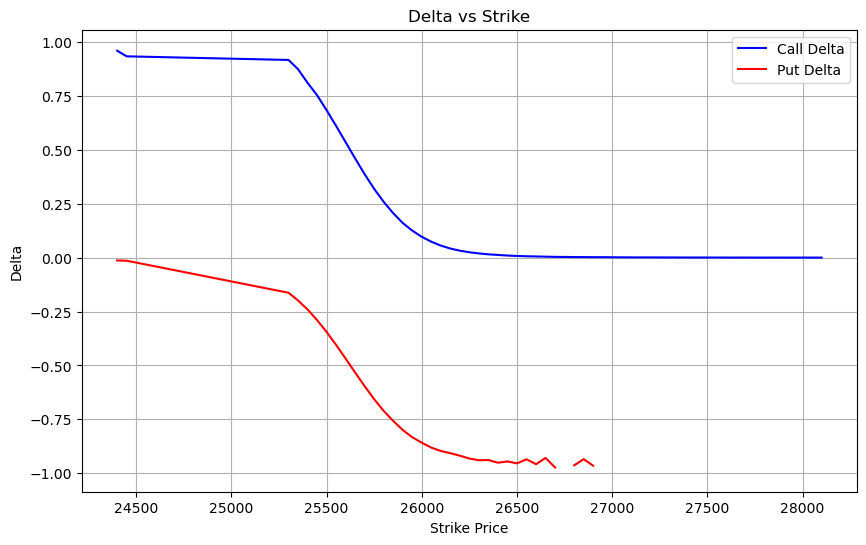

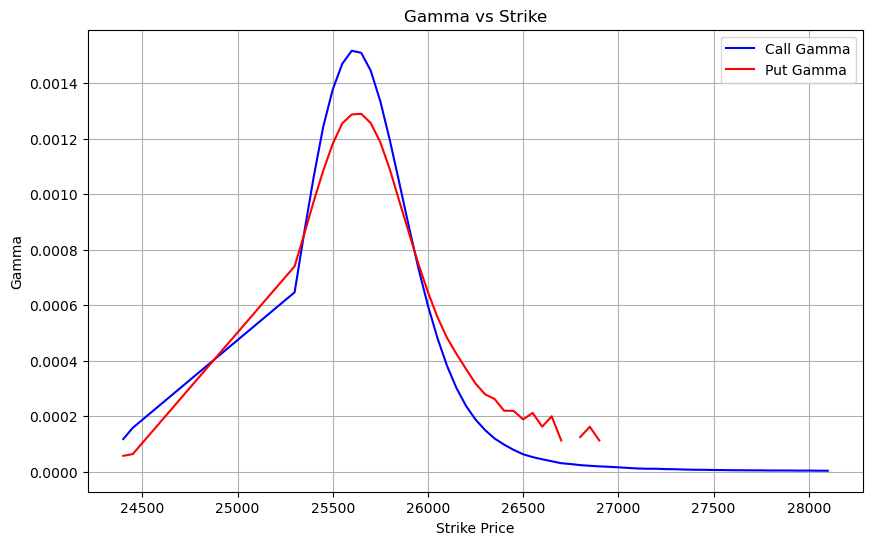

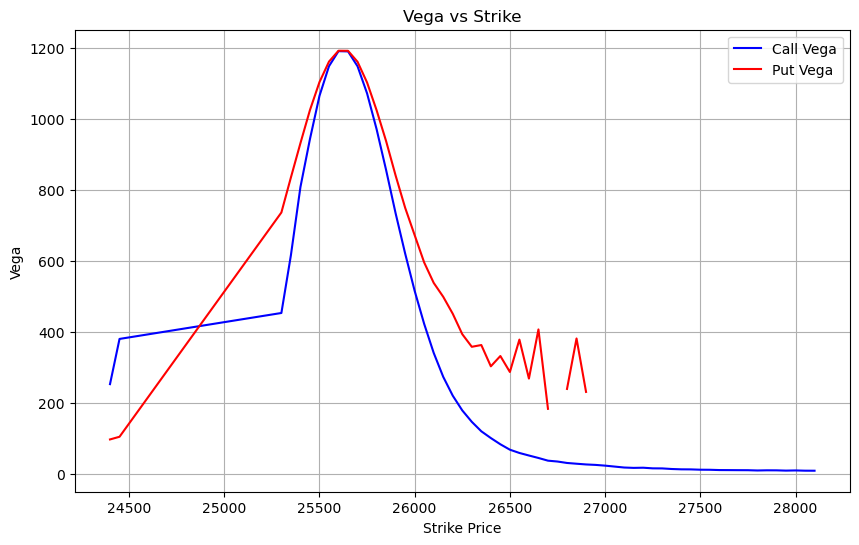

In [4]:
# Plot Delta
plt.figure(figsize=(10,6))
plt.plot(df["STRIKE"], df["CALLS_DELTA"], label="Call Delta", color="blue")
plt.plot(df["STRIKE"], df["PUTS_DELTA"], label="Put Delta", color="red")
plt.title("Delta vs Strike")
plt.xlabel("Strike Price")
plt.ylabel("Delta")
plt.legend()
plt.grid(True)
plt.show()

# Plot Gamma
plt.figure(figsize=(10,6))
plt.plot(df["STRIKE"], df["CALLS_GAMMA"], label="Call Gamma", color="blue")
plt.plot(df["STRIKE"], df["PUTS_GAMMA"], label="Put Gamma", color="red")
plt.title("Gamma vs Strike")
plt.xlabel("Strike Price")
plt.ylabel("Gamma")
plt.legend()
plt.grid(True)
plt.show()

# Plot Vega
plt.figure(figsize=(10,6))
plt.plot(df["STRIKE"], df["CALLS_VEGA"], label="Call Vega", color="blue")
plt.plot(df["STRIKE"], df["PUTS_VEGA"], label="Put Vega", color="red")
plt.title("Vega vs Strike")
plt.xlabel("Strike Price")
plt.ylabel("Vega")
plt.legend()
plt.grid(True)
plt.show()